In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime

from scipy import stats

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold

sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

In [2]:
pd.options.display.max_columns = 50

## Training Data

In [3]:
train_data = pd.read_csv('data/training_set.csv')

In [4]:
train_data.shape
train_data.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
train_data.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [6]:
def unique_categories(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            print(column, len(df[column].unique()))

In [7]:
def all_uniques(df):
    for column in df.columns:
        print(column, len(df[column].unique()))

In [8]:
def remove_features(df, extra_columns=None):
    df.drop(['id', 'num_private', 'recorded_by'], axis=1, inplace=True)
    if extra_columns:
        df.drop(extra_columns, axis=1, inplace=True)
    return df

In [9]:
all_uniques(train_data)

id 59400
amount_tsh 98
date_recorded 356
funder 1898
gps_height 2428
installer 2146
longitude 57516
latitude 57517
wpt_name 37400
num_private 65
basin 9
subvillage 19288
region 21
region_code 27
district_code 20
lga 125
ward 2092
population 1049
public_meeting 3
recorded_by 1
scheme_management 13
scheme_name 2697
permit 3
construction_year 55
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6


In [10]:
pd.isnull(train_data).any()

id                       False
amount_tsh               False
date_recorded            False
funder                    True
gps_height               False
installer                 True
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage                True
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting            True
recorded_by              False
scheme_management         True
scheme_name               True
permit                    True
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

In [11]:
def percent_missing(df):
    
    total = len(df)
    
    for column in df.columns:
        series = df[column]
        
        if series.dtype == 'object':
            if series.isnull().any():
                percentage = sum(series.isnull()) / total
                print(column, percentage * 100, 'NaN')
            elif series.str.contains('none').any():
                num = len(series[series == 'none'])
                percentage = num / total
                print(column, percentage * 100, 'none')
        elif series.dtype == 'float64':
            num = sum(abs(series) < 1e-6)
            percentage = num / total
            print(column, percentage * 100, '0')
        elif series.dtype == 'int64':
            num = sum(series == 0)
            percentage = num / total
            print(column, '{:.2f}'.format(percentage), '0')

In [12]:
percent_missing(train_data)

id 0.00 0
amount_tsh 70.0993265993 0
funder 6.11952861953 NaN
gps_height 0.34 0
installer 6.1531986532 NaN
longitude 3.05050505051 0
latitude 3.05050505051 0
wpt_name 5.998316498316498 none
num_private 0.99 0
subvillage 0.624579124579 NaN
region_code 0.00 0
district_code 0.00 0
population 0.36 0
public_meeting 5.61279461279 NaN
scheme_management 6.52693602694 NaN
scheme_name 47.4175084175 NaN
permit 5.14478114478 NaN
construction_year 0.35 0


## Training Labels

In [13]:
train_labels = pd.read_csv('data/training_labels.csv')

In [14]:
len(train_labels)

59400

In [15]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [16]:
train_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Make a copy of the training data for exploration and breaking.

In [17]:
df = train_data.copy()

# Initial Data Exploration

## Funders, Installers and Checkers

In [18]:
num_funders = len(df.funder.unique())
print('There are', '{:d}'.format(num_funders), 'different funders.')

There are 1898 different funders.


In [19]:
num_installers = len(df.installer.unique())
print('There are', '{:d}'.format(num_installers), 'different installers.')

There are 2146 different installers.


In [20]:
num_checkers = len(df.recorded_by.unique())
print('There are', '{:d}'.format(num_checkers), 'checkers.')

There are 1 checkers.


## Geography
### Longitude and Latitude

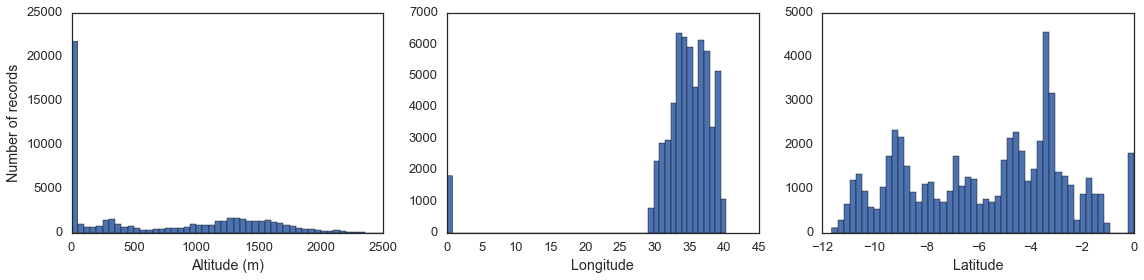

In [21]:
fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].hist(df.gps_height, bins=50, range=(0,2500))
ax[0].set_xlabel('Altitude (m)')
ax[0].set_ylabel('Number of records')
ax[1].hist(df.longitude, bins=50)
ax[1].set_xlabel('Longitude')
ax[2].hist(df.latitude, bins=50)
ax[2].set_xlabel('Latitude')


plt.tight_layout()

Latitude and longitude seem to have a set of reports with 0 values. Tanaznia does not capture either 0 lines of longitude or latitude, so they would appear to represent missing values.

We can check how many values are missing both or just one parts of this data.

In [22]:
df.longitude.min()

0.0

In [23]:
df.latitude.max()

-2e-08

In [24]:
print(len(df[(df.latitude > -1)]))
print(len(df[(df.longitude == 0)]))
print(len(df[(df.longitude == 0) & (df.id[df.latitude > -1])]))
print(len(df[(df.longitude != 0) & (df.latitude > -1)]))
print(len(df.id[(df.longitude == 0) & (df.id[df.latitude < -1])]))

1819
1812
1812
7
0


- records with missing latitude values: 1819
- records with missing longitude values: 1812
- records with missing latitude and longitude values: 1812
- records with missing latitude and longitude values: 1812
- records with missing *only* latitude values: 7
- records with missing *only* longitude values: 0

It is more difficult to determine whether altitude values of 0 are missing or at sea level. **<-- LOOK INTO THIS**

### Region

Assuming 0 is the code for missing value, then we can check if any of the coded region data is missing.

In [25]:
len(df[df.region_code == 0])

0

In [26]:
len(df[df.district_code == 0])

23

Hmm, ok. We should probably check whether 0 is the code for a region or representing a missing value. It's a pretty short list, so we might as well just have a look manually.

In [27]:
df[df.district_code == 0].head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
895,20639,0.0,2011-04-08,Water,0,Gover,36.526390,-6.57613,Kwa Mgoma,0,Wami / Ruvu,Ng'Ambo,Dodoma,1,0,Mpwapwa,Gode Gode,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other
2499,12416,0.0,2011-04-11,World Bank,0,world,36.666734,-6.41097,Mangwe,0,Wami / Ruvu,Mangwe,Dodoma,1,0,Mpwapwa,Matomondo,0,True,GeoData Consultants Ltd,VWC,Tamb,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


Ok, well from this it's still unclear what district code corresponds to and whether the zeros represent missing values or not. Let's have a look at another one to see.

In [28]:
df[df.district_code == 1].head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


It's still not clear what district code is exactly representing. I'm going to assume that it is a higher level boundary and that we probably won't bother taking it into account.

## Time
### Construction Year

In [29]:
df.construction_year.min()

0

In [30]:
df.construction_year.max()

2013

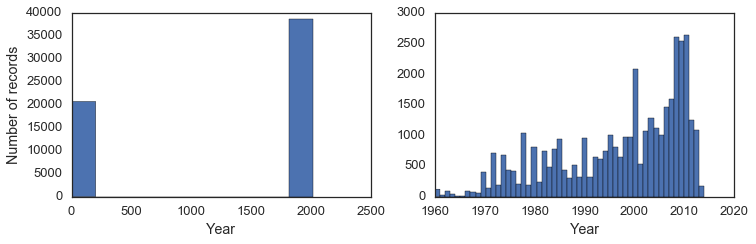

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10.6, 3.5))
ax[0].hist(df.construction_year)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of records')
ax[1].hist(df.construction_year[df.construction_year > 0], bins=53, range=[1960, 2014])
ax[1].set_xlabel('Year')

plt.tight_layout()

Unless a large number of water pumps were coincidentally installed to mark the birth of Jesus Christ, we see a large number of missing values for the year constructed, indicating that we don't know when around a third of the pumps were installed. 

Removing these shows us that the number of pumps installed generally increased since 1960, with a spike around 2000 and a reduction back to 2005 levels after 2010 (the data for 2013 is assumed to be incomplete).

### Year Recorded

In [32]:
df['date_recorded'].min()

'2002-10-14'

In [33]:
df['date_recorded'].max()

'2013-12-03'

It seeems that all recordings were taken between October 14th 2002 and December 3rd 2013. We will probably convert this to a unix time/date value.

# Water

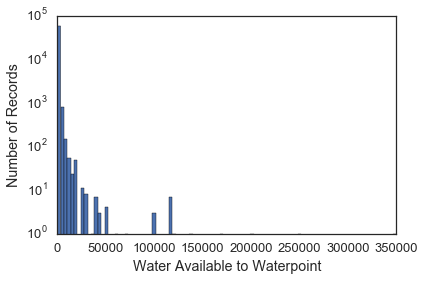

In [34]:
fig, ax = plt.subplots()
ax.hist(df.amount_tsh, bins=100, log=True)
ax.set_xlabel('Water Available to Waterpoint')
ax.set_ylabel('Number of Records')
plt.tight_layout()

We can see that the majority of pumps may have no information regarding the total static head (volume of water available).

Checking, we can see that 70% of records show a zero value for the total static head.

In [35]:
len(df[df.amount_tsh == 0]) / len(df)

0.700993265993266

# To Clean
**Initial**
- Convert date_recorded to numeric
- Convert categorical data to numeric
- Feature normalisation

**Advanced**
- Missing longitude and latitude values
- Missing date_constructed values
- Remove district_code
- Remove redundant and non-useful features

# Cleaning Phase 1
## Time Conversion

In [36]:
import datetime

In [37]:
then = datetime.datetime.strptime('2002-04-12', '%Y-%m-%d')

In [45]:
then.year

2002

In [39]:
epoch = datetime.datetime.utcfromtimestamp(0)
epoch

datetime.datetime(1970, 1, 1, 0, 0)

In [40]:
d = (then - epoch).days
d

11789

Probably useful so lets make a little convenience function for that.

In [41]:
def date_to_time(df, column='date_recorded'):
    epoch_day = datetime.datetime.utcfromtimestamp(0)
    days = [(datetime.datetime.strptime(day, '%Y-%m-%d') -  epoch_day).days for day in df[column]]
    df['time_recorded'] = days
    df.drop(column, axis=1, inplace=True)
    return df

Turning categories into dummies

In [42]:
df = pd.concat([df, pd.get_dummies(df['extraction_type_class'])], axis=1)
df.drop('extraction_type_class', axis=1, inplace=True)

In [43]:
df.head(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1,0,0,0,0,0,0


# Correlation

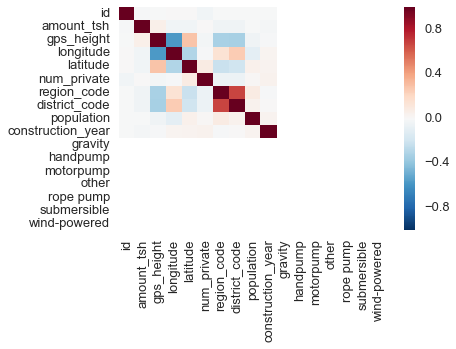

In [44]:
sns.heatmap(df[df != 0].corr(method='pearson', min_periods=1))

# Classifier Helper Functions

In [89]:
def macro_fscore(y_actual, y_predicted, num_categories=2):
    checks = np.zeros(num_categories)
    fscores = np.zeros(num_categories)
    
    cm = confusion_matrix(y_actual, y_predicted)
    for i in range(0, len(cm)):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        
        np.append(checks, [tp, fp, fn])
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        fscores[i] = (2 * precision * recall) / (precision + recall)
    
    macro_fscore = np.mean(fscores)
    
    return macro_fscore, fscores

In [90]:
def encode_categories(df, le, thresh=20):
    for column in df.columns:
        if df[column].dtype == 'object':
            if len(df[column].unique()) > thresh:
                df[column][pd.isnull(df[column])] = 'NaN'
                label_encoded = le.fit_transform(df[column])
                df[column] = label_encoded
            else:
                df = pd.concat([df, pd.get_dummies(df[column])], axis=1, copy=False)
                df.drop(column, axis=1, inplace=True)
    return df

In [91]:
def classification_rate(y_actual, y_predicted):
    rate = np.sum(y_actual == y_predicted) / len(y_actual)
    return rate

# Model 1

**Random Forest Classifier**
- All features (except ID)
- Conversion of non-numeric categories to a mix of label encoded and one hot encoded values
- No filling in missing values

Remove ID and num_private columns

In [545]:
train_data_1 = train_data.copy()
train_data_1 = train_data_1.drop('id', axis=1)
train_data_1 = train_data_1.drop('num_private', axis=1)
train_data_1 = train_data_1.drop('recorded_by', axis=1)

Convert date recorded to number of days since epoch.

In [546]:
train_data_1 = date_to_time(train_data_1)

Replace non-numerica categorical values with label encoded and one hot encoded logical values

In [547]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le_lab = preprocessing.LabelEncoder()


In [548]:
train_data_1 = encode_categories(train_data_1, le)

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Prepare test data.

In [549]:
train_labels_1 = train_labels.copy()
label_encoded = le_lab.fit_transform(train_labels_1['status_group'])
train_labels_1['status_group'] = label_encoded

In [550]:
train_1 = train_data_1.join(train_labels_1['status_group'])

In [551]:
train_1.head(1)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,subvillage,region,region_code,district_code,lga,ward,population,scheme_name,construction_year,time_recorded,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,...,unknown,borehole,dam,other,rainwater harvesting,river/lake,shallow well,spring,groundwater,surface,unknown,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,cattle trough,communal standpipe,dam,hand pump,improved spring,other,status_group
0,6000.0,1370,1390,1519,34.938093,-9.856322,37399,11807,3,11,5,51,1426,109,2246,1999,15047,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


In [552]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=3)

In [553]:
kf = KFold(train_data_1.shape[0], n_folds=5, random_state=1)

In [554]:
pred = []

for train, test in kf:
    X = train_data_1.iloc[train, :]

    y = train_labels_1['status_group'].iloc[train]

    clf.fit(X, y)

    test_pred = clf.predict(train_data_1.iloc[test, :])
    pred = np.append(pred, test_pred)

In [65]:
from sklearn.metrics import confusion_matrix

In [555]:
cm = confusion_matrix(train_labels_1['status_group'], pred)
cm

array([[28793,   838,  2628],
       [ 2181,  1503,   633],
       [ 4591,   357, 17876]])

In [556]:
macro_f, fscores = macro_fscore(train_labels_1['status_group'], pred, num_categories=3)
macro_f

0.69694237427508632

In [557]:
rate = classification_rate(train_labels_1['status_group'], pred)
rate

0.81097643097643102

# Model 2

**Random Forest Classifier**
- All features (except ID)
- Conversion of non-numeric categories to a mix of label encoded
- No filling in missing values
- Tune n_estimators

In [114]:
train_data_2 = train_data_1.copy()
train_labels_2 = train_labels_1.copy()

In [115]:
kf = KFold(train_data_2.shape[0], n_folds=5, random_state=0)

In [132]:
estimators = [1, 10, 50, 100]

classification_rates = []
predictions = []

for estimator in estimators:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=0)
    pred = []
    
    for train, test in kf:
        X = train_data_2.iloc[train, :]
    
        y = train_labels_2['status_group'].iloc[train]
    
        clf.fit(X, y)
        
        test_pred = clf.predict(train_data_1.iloc[test, :])
        pred = np.append(pred, test_pred)
    
    predictions = np.append(predictions, pred)
    classification_rates.append(classification_rate(train_labels_2['status_group'], pred))

In [133]:
classification_rates

[0.72966329966329968,
 0.79712121212121212,
 0.8085016835016835,
 0.8103030303030303]

We can see that although we use a larger number of estimators, the classification rate converges very quickly.

Checking the macro-F score for the iteration with 100 estimators, no difference compared to using the 10 states previously.

In [134]:
cm = confusion_matrix(train_labels_2['status_group'], pred)
cm

array([[28785,   845,  2629],
       [ 2164,  1507,   646],
       [ 4612,   372, 17840]])

In [135]:
macro_f, fscores = macro_fscore(train_labels_2['status_group'], pred, num_categories=3)
macro_f

0.69632123454829775

# Model 3

**Random Forest Classifier**
- All features (except ID)
- Conversion of non-numeric categories to a mix of label encoded and one hot encoded values
- No filling in missing values
- Tune depth

In [137]:
train_data_3 = train_data_1.copy()
train_labels_3 = train_labels_1.copy()

In [138]:
kf = KFold(train_data_3.shape[0], n_folds=5, random_state=1)

In [139]:
depths = [1, 10, 50, 100, 500]

classification_rates = []

for depth in depths:
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    pred = np.empty(0)
    
    for train, test in kf:
        X = train_data_3.iloc[train,:]
    
        y = train_labels_3['status_group'].iloc[train]
    
        clf.fit(X, y)
        
        test_pred = clf.predict(train_data_3.iloc[test, :])
        pred = np.append(pred, test_pred)
        d
    classification_rates.append(classification_rate(train_labels_3['status_group'], pred))

In [140]:
classification_rates

[0.63163299663299666,
 0.75109427609427615,
 0.79722222222222228,
 0.79712121212121212,
 0.79712121212121212]

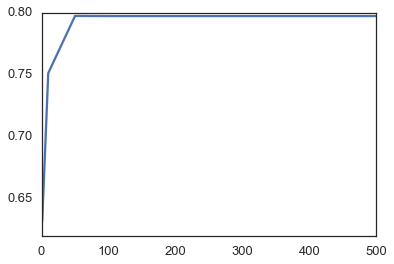

In [144]:
plt.plot(depths, classification_rates, '-')

Using a larger maximum depth actually results in a decrease in accuracy.

Checking the macro-F score for the iteration with the deepest classifier, we find ourselves stuck around the same values.

In [145]:
cm = confusion_matrix(train_labels_2['status_group'], pred)
cm

array([[28594,   939,  2726],
       [ 2246,  1441,   630],
       [ 5078,   432, 17314]])

In [146]:
macro_f, fscores = macro_fscore(train_labels_2['status_group'], pred, num_categories=3)
macro_f

0.67974555799984737

# Model 4

**Random Forest Classifier**
- All features (except ID)
- Conversion of non-numeric categories to a mix of label encoded
- Fill in missing values
- Tune depth

In [168]:
train_data_4 = train_data.copy()
train_labels_4 = train_labels.copy()
train_data_4 = train_data_4.drop('id', axis=1)
train_data_4 = train_data_4.drop('num_private', axis=1)
train_data_4 = train_data_4.drop('recorded_by', axis=1)

train_data_4 = date_to_time(train_data_4)

label_encoded = le.fit_transform(train_labels_4['status_group'])
train_labels_4['status_group'] = label_encoded

In [169]:
train_data_4.head(1)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,time_recorded
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,15047


In [594]:
dave = 2.54
if True:
    dave = int(dave)
dave

2

In [170]:
def fill_missing_values_simple(df):
    for column in df.columns:
        series = df[column]

        if series.dtype == 'object':
            print(column)
            #series = [str(entry) for entry in series]
            
            #series = pd.Series(series)
            
            series[pd.isnull(series)] = 'NaN'
            
            if series.str.contains('NaN').any():
                if series.mode()[0] == 'NaN':
                    series_temp = series[series != 'NaN']
                    modal = series_temp.mode()[0]
                else:
                    modal = series.mode()[0]
                    
                df[column][series == 'NaN'] = modal
            elif series.str.contains('none').any():
                if series.mode()[0] == 'none':
                    series_temp = series[series != 'none']
                    modal = series_temp.mode()[0]
                else:
                    modal = series.mode()[0]
                    
                df[column][series == 'none'] = modal
                
        elif series.dtype == 'float64':
            missing = abs(0 - abs(series)) < 10e-6
            not_missing = series[missing == False]
            med = not_missing.median()
            df[column][missing] = med
            
        elif (series.dtype == 'int64') & (0 in series):
            missing = series == 0
            not_missing = series[missing == False]
            med = int(not_missing.median())
            df[column][missing] = med
        else:
            continue
    return df

In [171]:
train_data_4 = fill_missing_values_simple(train_data_4)

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


funder


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


installer
wpt_name


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


basin
subvillage
region
lga
ward
public_meeting
scheme_management
scheme_name
permit
extraction_type
extraction_type_group
extraction_type_class
management
management_group
payment
payment_type
water_quality
quality_group
quantity
quantity_group
source
source_type
source_class
waterpoint_type
waterpoint_type_group


In [172]:
train_data_4.head(1)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,time_recorded
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,Shuleni,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,15047


In [173]:
def label_encode_categories(df, le):
    for column in df.columns:
        #print(column)
        if (df[column].dtype == 'object'):
            df[column][pd.isnull(df[column])] = 'NaN'
            label_encoded = le.fit_transform(df[column])
            df[column] = label_encoded
    return df

In [174]:
train_data_4 = label_encode_categories(train_data_4, le)

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [175]:
train_data_4.head(1)

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,time_recorded
0,6000.0,1369,1390,1518,34.938093,-9.856322,35529,1,11807,3,11,5,51,1426,109,1,7,2245,0,1999,3,1,0,7,4,2,0,6,2,1,1,8,6,0,1,1,15047


Now that we have all of the data label encoded, we can have a peek at the correlation between all of the features. A few notable things jump out. The Pearson correlation matrix shows relationships between several features, suggesting that some feature reduction algorithm may be useful to improve the training of our algorithm.

In particular features that would appear to duplicate information show highly correlated spots, such as:
- gps height, longitude and latitude
- installer and funder
- district code and region code
- management, management group and management scheme
- payment and payment type
- waterpoint type and waterpoint type class
- quantity group and quantity
- waterpoint type and extraction type

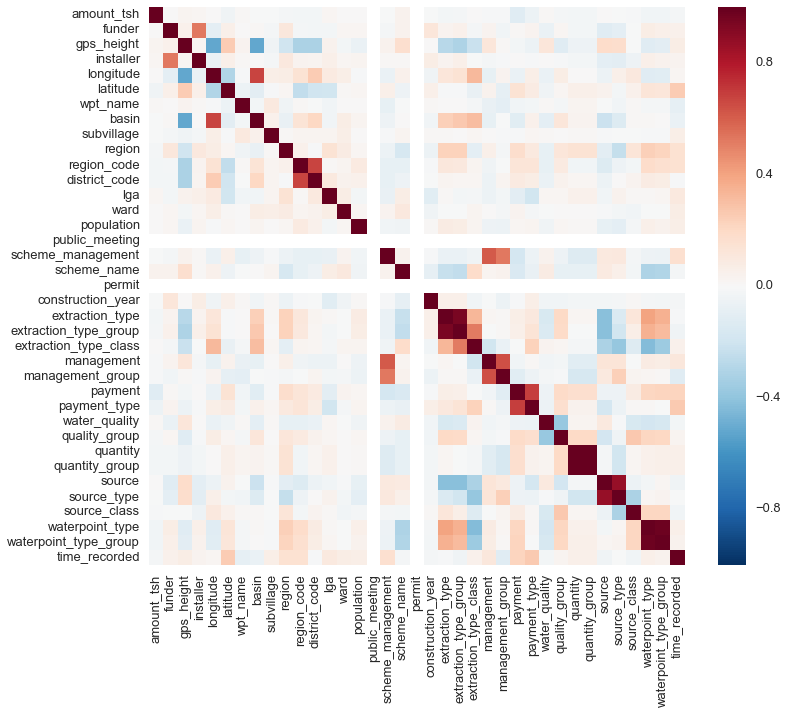

In [176]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(train_data_4[train_data_4 != 0].corr(method='pearson', min_periods=1))

In [247]:
clf = RandomForestClassifier(n_estimators=50)

In [248]:
pred = []
for train, test in kf:
        X = train_data_4.iloc[train,:]
    
        y = train_labels_4['status_group'].iloc[train]
    
        clf.fit(X, y)
        
        test_pred = clf.predict(train_data_4.iloc[test, :])
        pred = np.append(pred, test_pred)

In [181]:
rate = classification_rate(train_labels_4['status_group'], pred)
rate

0.79823232323232318

Still no improvement. It looks as though we may have an overfitting problem as we score much lower on the test data.

### Checking for Overfitting

In [183]:
n_samples = [5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]

In [199]:
merged_data = train_data_4.join(train_labels_4['status_group'])

In [208]:
cv_rate = []
train_rate = []

for sample_size in n_samples:
    
    sample_data = merged_data.sample(n=sample_size, random_state=0)
    
    sample_labels = sample_data.pop('status_group')
    
    kf = KFold(sample_data.shape[0], n_folds=5, random_state=0)
    
    cv_predictions = []
    train_predictions = []
    
    for train, cv in kf:
        X = sample_data.iloc[train, :]
    
        y = sample_labels.iloc[train]
    
        clf.fit(X, y)
        
        cv_pred = clf.predict(sample_data.iloc[cv, :])
        cv_predictions = np.append(cv_predictions, cv_pred)
        
    train_predictions = clf.predict(sample_data)
    #train_predictions = np.append(train_predictions, train_pred)
    
    cv_rate = np.append(cv_rate, classification_rate(sample_labels, cv_predictions))
    train_rate = np.append(train_rate, classification_rate(sample_labels, train_predictions))   

(0.6, 1)

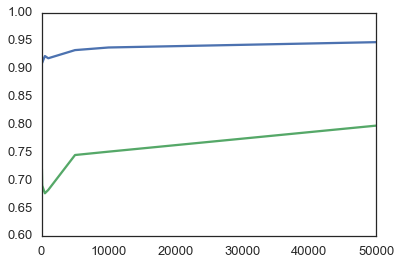

In [221]:
fig, ax = plt.subplots(1,1)
ax.plot(n_samples, train_rate, n_samples, cv_rate)
ax.set_ylim(0.6, 1)

It appears that the model has high variance -> it is overfitting on the training data. Seeing as we have a fixed amount of data, we are best of reducing and engineering features.

# Model 5
With SVM or PCA

# Model 6
With feature reduction and clever missing values

For each column with missing values present and for every record that has a missing value, use k-nearest neighbours clustering to find samples most like the record in question. For numerical data, take the mean value of the missing feature from the nearest neighbours. For categorical variables find the probability distribution of the missing value among the neighbours and then assign the value with the highest probability to the missing value.

```
remove redundant features (highly correlated of less granularity)

for each column{
   if dtype == object{
       find and store indices of missing values (create boolean)
       binary encode column
   }
   else if dtype == float or int{
       find and store indices of missing values (create boolean)
   }
}

for each column{
    
    copy dataframe and drop rows with missing values in column
    drop column from new dataframe
    perform knn on new dataframe
    
    if dtype == object{
        predict cluster for dropped rows
        find distribution of missing value in all clusters
        find value with max probability for each cluster
        for each dropped row{
            set missing value in dropped column to max probability value from cluster 
        }
    }
    else if dtype == float{
        predict cluster for dropped rows
        find mean value with for each cluster
        for each dropped row{
            set missing value in dropped column to mean value from cluster 
        }
    }
}
```


In [249]:
train_data_6 = train_data.copy()
train_labels_6 = train_labels.copy()
train_data_6 = train_data_6.drop('id', axis=1)
train_data_6 = train_data_6.drop('num_private', axis=1)
train_data_6 = train_data_6.drop('recorded_by', axis=1)
train_data_6 = date_to_time(train_data_6)

In [603]:
dave = pd.Series([False, False, False])

dave.any()

False

In [223]:
def missing_dataframe(df):
    
    df_missing = df.copy()
    
    for column in df.columns:
        series = df[column]
        
        if series.dtype == 'object':
            series.replace('NaN', np.nan, inplace=True)
            
            if series.isnull().any():
                df_missing[column] = series.isnull()
    
            elif series.str.contains('none').any():
                df_missing[column] = series.str.contains('none')
            
            else:
                df_missing.drop(column, axis=1, inplace=True)
                
        elif series.dtype == 'float64':
            missings = abs(0 - abs(series)) < 10e-6
            if (missings == True).any():
                df_missing[column] = missings
            else:
                df_missing.drop(column, axis=1, inplace=True)
            
        elif series.dtype == 'int64':
            missings = series == 0
            if (missings == True).any():
                df_missing[column] = missings
            else:
                df_missing.drop(column, axis=1, inplace=True)
            
    return df_missing

In [224]:
def max_uniques(df):
    uniques = []
    for column in df.columns:
        series = df[column]
        if series.dtype == 'object':
            uniques.append(len(series.unique()))
    bin_length = len('{0:b}'.format(max(uniques)))
    return bin_length

In [225]:
def binary_uniques(s):
    bin_length = len('{0:b}'.format(len(s.unique())))
    return bin_length

In [226]:
def binary_encode(df):
    
    '''
    returns
    df_binary - dataFrame with catergoric variables encoded as binary values and separated
    df_binary_str - dataFrame with categoric variables encoded as strings of their binary values
    binary_headers - the headers for df_binary
    '''
    
    le = preprocessing.LabelEncoder()
    
    df_binary = df.copy()
    df_binary_str = df.copy()
    
    binary_headers = []
    
    for column in df.columns:
        
        #print(column)
        
        series = df[column]     
        
        if series.dtype == 'object':
            
            series = series.apply(lambda x: str(x))
            bin_length = binary_uniques(series)
            #print(bin_length)
            
            label_encoded = le.fit_transform(series)
            
            #binary_column = ['{0:b}'.format(label).zfill(bin_length) for label in label_encoded]
            binary_column = ['{0:b}'.format(label).zfill(20) for label in label_encoded]
            df_binary_str[column] = binary_column
            
            binary_columns = [list(binary) for binary in binary_column]         
            
            #binary_header = [column + '_' + str(i) for i in range(0, bin_length)]
            binary_header = [column + '_' + str(i) for i in range(0, 20)]
            binary_headers.append(binary_header)
            
            #print(bin_length)
            #print(binary_header)
            
            binary_df_temp = pd.DataFrame(binary_columns, columns=binary_header)
            
            df_binary.drop(column, axis=1, inplace=True)
            df_binary = pd.concat([df_binary, binary_df_temp], axis=1)
            
        else:
            binary_headers.append(column)
            
        binary_headers = [header for sub_list in binary_headers for header in sub_list]
            
    return df_binary, df_binary_str, binary_headers

In [373]:
def fill_missing_values_knn(df_binary, df_binary_str, df_missing, binary_headers):
    # df_binary - fully encoded dataframe
    # df_missing - flags True wherever value in column is missing
    # df_binary_str - encoded with string binary values
    # binary_headers - header values for object type columns in df_binary
    
    le = preprocessing.LabelEncoder()
    
    b_h = [header for sub_list in binary_headers for header in sub_list if len(header) > 1]
    
    df_missing_inv = df_missing == False # flags True wherver a value is present
    
    for column in df_missing.columns: # loop through all columns where missing values are present
        print(column)
        if df_binary_str[column].dtype == 'float64': # for floats
            
            series_present = df_missing_inv[column]         # create series flagging where the present values are
            series_missing = df_missing[column]
            
            df_binary_temp = df_binary.drop(column, axis=1) # drop column missing values we care about
            df_binary_temp = df_binary_temp[series_present] # create X input for our classifier
            
            df_binary_labels = df_binary_str[column] # get relevant column of values from partially encoded dataframe
            # select only rows without missing values for y input
            df_binary_labels = df_binary_labels[series_present].astype(int)
            df_binary_labels = df_binary_labels.values.reshape(-1)
            #df_binary_labels.tolist()
            
            neigh = KNeighborsClassifier(n_neighbors=5) # instantiate classifier
            
            neigh.fit(df_binary_temp, df_binary_labels) # fit classifier to rows with labels
            
            # create dataframe of rows with missing values for fitting
            df_binary_missing = df_binary[series_missing] 
            df_binary_missing.drop(column, axis=1, inplace=True)
            
            label, index = neigh.kneighbors(df_binary_missing, n_neighbors=5) # fit and get indices of 5 neighbours
            
            missing_means = [np.mean(df_binary_labels[i]) for i in index]
            df_binary[column][series_missing] = missing_means        
            
        elif df_binary_str[column].dtype == 'int64':
            series_present = df_missing_inv[column]         # create series flagging where the present values are
            series_missing = df_missing[column]
            
            df_binary_temp = df_binary.drop(column, axis=1) # drop column missing values we care about
            df_binary_temp = df_binary_temp[series_present] # create X input for our classifier
            
            df_binary_labels = df_binary_str[column] # get relevant column of values from partially encoded dataframe
            df_binary_labels = df_binary_labels[series_present].astype(int) # select only rows without missing values for y input
            df_binary_labels = df_binary_labels.values.reshape(-1)
            #df_binary_labels.tolist()
            
            # instantiate classifier
            neigh = KNeighborsClassifier(n_neighbors=5) 
            
            # fit classifier to rows with labels
            neigh.fit(df_binary_temp, df_binary_labels) 
            
            # create dataframe of rows with missing values for fitting
            df_binary_missing = df_binary[series_missing] 
            df_binary_missing.drop(column, axis=1, inplace=True)
            
            # fit and get indices of 5 neighbours
            label, index = neigh.kneighbors(df_binary_missing, n_neighbors=5) 
            
            missing_means = [int(np.mean(df_binary_labels[i])) for i in index]
            df_binary[column][series_missing] = missing_means
        
        elif df_binary_str[column].dtype == 'object':
            
            # booleans indicating rows where values in feature are present and missing
            series_present = df_missing_inv[column]
            series_missing = df_missing[column]
            
            # get header names of all columns in binary encoded feature
            columns = [c for c in b_h if re.search(column, c)]
            
            # dataFrame with columns of interest dropped
            df_binary_temp = df_binary.drop(columns, axis=1)
            # keep only rows where values exist in the feature of interest
            df_binary_temp = df_binary_temp[series_present]
            
            # grab string based binary labels for feature of interest where values exist
            df_binary_labels = df_binary_str[column]          
            df_binary_labels = df_binary_labels[series_present]
            
            #df_binary_labels_encode = le.fit_transform(df_binary_labels)
            
            # reshape labels into numpy array
            df_binary_labels = df_binary_labels.values.reshape(-1)
            
            # create classifier based on all other features where feature values exist
            neigh = KNeighborsClassifier(n_neighbors=5)
            neigh.fit(df_binary_temp, df_binary_labels)
            
            # create dataFrame of rows where feature value is missing excluding current feature column
            df_binary_missing = df_binary[series_missing]
            df_binary_missing.drop(columns, axis=1, inplace=True)
            
            # 
            label, indices = neigh.kneighbors(df_binary_missing, n_neighbors=5)
            
            #print(df_binary_labels)
            #print(label)
            #print(indices)
            
            missing_mode = [stats.mode(df_binary_labels[i]) for i in indices]
            #print(missing_mode)
            missing_mode = [list(list(x.mode)[0]) for x in missing_mode]
            df_insert = pd.DataFrame(missing_mode)
            df_binary[columns][series_missing] = df_insert
            
    return df_binary

In [296]:
df_missing = missing_dataframe(train_data_6)
df_binary, df_binary_str, binary_headers = binary_encode(train_data_6)

In [374]:
df_test = fill_missing_values_knn(df_binary, df_binary_str, df_missing, binary_headers)

amount_tsh


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


funder


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/pandas/core/frame.py:

gps_height


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


installer
longitude
latitude
wpt_name
subvillage
district_code
population
public_meeting
scheme_management
scheme_name
permit
construction_year


In [376]:
clf = RandomForestClassifier()

In [377]:
kf = KFold(df_test.shape[0], n_folds=5, random_state=0)

In [378]:
pred = []

for train, test in kf:
    X = df_test.iloc[train,:]

    y = train_labels_6['status_group'].iloc[train]

    clf.fit(X, y)

    test_pred = clf.predict(df_test.iloc[test, :])
    pred = np.append(pred, test_pred)

In [379]:
rate = classification_rate(train_labels_6['status_group'], pred)
rate

0.801969696969697

In [11]:
def cat_to_dummy(df, column):
    for column in df.columns:
        if df[column].dtype == 'object':
            df = pd.concat([df, pd.get_dummies(df[column])], axis=1, copy=False)
            df.drop(column, axis=1, inplace=True)
    return df

# Model 7
Manual feature removal

In [498]:
train_data_7 = train_data.copy()
train_labels_7 = train_labels.copy()

to_remove = ['waterpoint_type', 'source_type', 'source_class', 'quantity_group', 'quality_group', 'payment_type',\
             'scheme_management', 'extraction_type_group', 'extraction_type_class', 'region_code', 'district_code',\
            'funder', 'amount_tsh', 'gps_height', 'scheme_name']

remove_features(train_data_7, extra_columns=to_remove)
train_data_7 = date_to_time(train_data_7)

In [499]:
df_missing = missing_dataframe(train_data_7)
df_binary, df_binary_str, binary_headers = binary_encode(train_data_7)

In [500]:
df_test = fill_missing_values_knn(df_binary, df_binary_str, df_missing, binary_headers)

installer


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/pandas/core/frame.py:

longitude


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


latitude
wpt_name
subvillage
population


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


public_meeting
permit
construction_year


In [501]:
clf = RandomForestClassifier(n_estimators=200)

In [502]:
kf = KFold(df_test.shape[0], n_folds=5, random_state=0)

In [503]:
pred = []

for train, test in kf:
    X = df_test.iloc[train,:]

    y = train_labels_7['status_group'].iloc[train]

    clf.fit(X, y)

    test_pred = clf.predict(df_test.iloc[test, :])
    pred = np.append(pred, test_pred)

In [504]:
rate = classification_rate(train_labels_7['status_group'], pred)
rate

0.7945117845117845

In [460]:
n_samples = [5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]

In [463]:
merged_data = df_test.join(train_labels_7['status_group'])

In [464]:
cv_rate = []
train_rate = []

for sample_size in n_samples:
    
    sample_data = merged_data.sample(n=sample_size, random_state=0)
    
    sample_labels = sample_data.pop('status_group')
    
    kf = KFold(sample_data.shape[0], n_folds=5, random_state=0)
    
    cv_predictions = []
    train_predictions = []
    
    for train, cv in kf:
        X = sample_data.iloc[train, :]
    
        y = sample_labels.iloc[train]
    
        clf.fit(X, y)
        
        cv_pred = clf.predict(sample_data.iloc[cv, :])
        cv_predictions = np.append(cv_predictions, cv_pred)
        
    train_predictions = clf.predict(sample_data)
    #train_predictions = np.append(train_predictions, train_pred)
    
    cv_rate = np.append(cv_rate, classification_rate(sample_labels, cv_predictions))
    train_rate = np.append(train_rate, classification_rate(sample_labels, train_predictions))  

(0.6, 1)

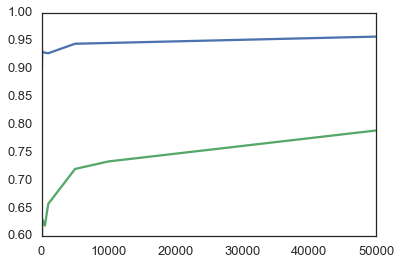

In [465]:
fig, ax = plt.subplots(1,1)
ax.plot(n_samples, train_rate, n_samples, cv_rate)
ax.set_ylim(0.6, 1)

# Model 8
- Simple missing values
- Manual feature removal

In [505]:
train_data_8 = train_data.copy()
train_labels_8 = train_labels.copy()
to_remove = ['waterpoint_type', 'source_type', 'source_class', 'quantity_group', 'quality_group', 'payment_type',\
             'scheme_management', 'extraction_type_group', 'extraction_type_class', 'region_code', 'district_code',\
            'funder', 'amount_tsh', 'gps_height', 'scheme_name']

remove_features(train_data_8, extra_columns=to_remove)

train_data_8 = date_to_time(train_data_8)

In [506]:
train_data_8 = fill_missing_values_simple(train_data_8)

train_data_8 = label_encode_categories(train_data_8, le)

installer


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


wpt_name


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


basin
subvillage
region
lga
ward


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


public_meeting
permit
extraction_type
management
management_group
payment
water_quality
quantity
source
waterpoint_type_group


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [542]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=3)

In [543]:
pred = []
for train, test in kf:
        X = train_data_8.iloc[train,:]
    
        y = train_labels_8['status_group'].iloc[train]
    
        clf.fit(X, y)
        
        test_pred = clf.predict(train_data_8.iloc[test, :])
        pred = np.append(pred, test_pred)

In [544]:
rate = classification_rate(train_labels_8['status_group'], pred)
rate

0.80949494949494949

# Predictions

In [564]:
test_data = pd.read_csv('data/test_set.csv')

In [565]:
test_data = test_data.drop('id', axis=1)
test_data = test_data.drop('num_private', axis=1)
test_data = test_data.drop('recorded_by', axis=1)
test_data = date_to_time(test_data)

In [566]:
test_data = encode_categories(test_data, le)

/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [454]:
df_missing_test = missing_dataframe(test_data)
df_binary_test, df_binary_str_test, binary_headers_test = binary_encode(test_data)

In [455]:
df_test_submit = fill_missing_values_knn(df_binary_test, df_binary_str_test, df_missing_test, binary_headers_test)

amount_tsh


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


gps_height


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


longitude
latitude
wpt_name


/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/scipy/stats/stats.py:257: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/George/miniconda3/envs/py3k/lib/python3.5/site-packages/pandas/core/frame.py:

subvillage
population
public_meeting
scheme_name
permit
construction_year


In [567]:
pred_test = clf.predict(test_data)

ValueError: Number of features of the model must  match the input. Model n_features is 168 and  input n_features is 166 

In [457]:
submission = pd.read_csv('data/SubmissionFormat.csv')

In [397]:
le_lab = preprocessing.LabelEncoder()
le_lab.fit(pred_test)
pred_labels = le_lab.inverse_transform(pred_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [458]:
submission.status_group = pred_test

In [459]:
submission.to_csv('submissions/submission6.csv', index=False)